# Proyecto Bank Marketing

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import statsmodels as sm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report,roc_auc_score,roc_curve,auc

# Exploración inicial y limpieza de datos

In [2]:
# Se carga el DataFrame con pandas en Datos_crudos. Se realiza tambien una copia de este DataFrame en Datos, para poder
# Manipularlo teniendo de backup Datos_crudos:

Datos_crudos = pd.read_excel('bank-additional-full2.xlsx')
Datos = Datos_crudos.copy()

In [3]:
# Veo cantidad de filas y columnas:

Datos.shape

(41188, 21)

In [4]:
# Veo inicialmente que columnas tenemos y si se cargo bien el Dataset. Tambien expando el numero de columnas que puede
# mostrar pandas para ver todas. De otra manera no podria visualizar las 21:
pd.set_option('display.max_columns', 500)
Datos.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93994.0,-36.4,4857.0,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93994.0,-36.4,4857.0,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93994.0,-36.4,4857.0,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93994.0,-36.4,4857.0,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93994.0,-36.4,4857.0,5191.0,no


In [5]:
# Veo que tipo de datos tiene el DataSet:

Datos.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [6]:
# Voy a eliminar la columna 'duration', ya que el texto provisto indica que no es un valor que se tenga que tener en
# cuenta en el modelo, ya que luego de la llamada ya se sabe si la persona acepto o no el deposito. Es por esto que este
# valor no proporciona ninguna información relevante:

Datos = Datos.drop(columns = 'duration', axis = 1)

In [7]:
# Voy a revisar si encuentro valores nulos, aunque ya en el texto aclaran que todos los nulos fueros reemplazados por
# 'Unknown'

Datos.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Efectivamente no hay nulos. No voy a eliminar ni a reemplazar los 'unknown' ya que puede resultar interesante tomarlos
como una categoria. Entiendo que podria estar perdiendo información valiosa si simplemente los descarto.

# Analisis escrito de los datos observados, utilizando la descripcion de cada columna provista junto con el ejercicio:

A priori no parece haber ninguna transformación necesaria. Estaba buscando básicamente si había algún valor numérico
con dtype object (string).
Resulta interesante poder relacionar algunos de los datos característicos de las personas, como 
edad, sexo, empleo, estado civil, educación, si tienen prestamos asignados y en qué momento se
realizo la llamada para ver si estas variables pueden ser útiles para predecir si la persona va a
tomar el depósito o no.

Por otro lado tenemos las siguientes variables:

Employment variation rate: Es una medida de la variación del empleo que se mide
cada cuarto y está asociada directamente al momento del año en el que se realizó el contacto con la persona. 
Sería interesante ver si existe correlación entre este valor y la decisión de tomar o no el depósito, 
ya que sería de esperar que al existir un cambio negativo en la tasa de empleo, la persona sea mas conservadora con los 
prestamos que toma.

consumer price index: Es una medida de los precios de bienes y servicios en un rango de tiempo, en este caso medido
mensualmente. También resulta interesante medir su correlación con la decisión de la toma del 
deposito, ya que es una medida de la salud financiera general de la población. Si el precio de
bienes y servicios es elevado, seria de esperar que las personas sean conservadoras con los
prestamos que toman.

Consumer confidence index: Es una medida de cuanto la población esta gastando. Mientras mayor sea
esperaría que mayor sea la probabilidad de que se tome el deposito.

euribor 3 month rate: Índice que indica la tasa de interés de préstamos que están dispuestos
a dar los bancos, medido diariamente.

number of employees: Indicador de la cantidad de personas empleadas, tendría que aportar
información similar a Employment variation rate.

# Analisis descriptivo de los datos:

In [8]:
# Voy a ver algunos valores estadisticos para ver si hay alguna información útil que salte a la vista:

Datos.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,85401.579955,-40.502600,3180.107207,5167.035911
std,10.42125,2.770014,186.910907,0.494901,1.570960,26471.506796,4.628198,2086.690436,72.251528
min,17.00000,1.000000,0.000000,0.000000,-3.400000,93.200000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,92893.000000,-42.700000,1281.000000,5099.100000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93749.000000,-41.800000,4856.000000,5191.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93994.000000,-36.400000,4961.000000,5228.100000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94767.000000,-26.900000,5045.000000,5228.100000


No tiene mucho sentido ver los valores de pdays ya que el 999 simboliza que no se contacto al cliente previamente.
emp.var.rate presenta una diferencia de alrededor de 8% entre su mediana y el cuartil 50%. Esto podria indicar la
existencia de outliers o una distribución no gaussiana. Lo mismo sucede con cons.price.idx y euribor3m, y lo interesante
es que todos tienen una mediana menor que el cuartil 50%. Siendo los 3 parametros indicadores de salud financiera, 
podrian tener relación entre si.

In [9]:
# Voy a crear una Lista de categorias de edad, para poder hacer una mejor visualización de las distribuciones de edades:

Categoria_Edad = []
for i in range(len(Datos)):
    if Datos.loc[i,'age'] < 20:
        Categoria_Edad.append('Menor a 20')
        i =+ 1
    elif Datos.loc[i,'age'] < 31:
        Categoria_Edad.append('Entre 20 y 30')
        i =+ 1
    elif Datos.loc[i,'age'] < 36:
        Categoria_Edad.append('Entre 31 y 35')
        i =+ 1
    elif Datos.loc[i,'age'] < 41:
        Categoria_Edad.append('Entre 36 y 40')
        i =+ 1
    elif Datos.loc[i,'age'] < 46:
        Categoria_Edad.append('Entre 41 y 45')
        i =+ 1
    elif Datos.loc[i,'age'] < 51:
        Categoria_Edad.append('Entre 46 y 50')
        i =+ 1
    elif Datos.loc[i,'age'] < 56:
        Categoria_Edad.append('Entre 51 y 55')
        i =+ 1
    elif Datos.loc[i,'age'] < 61:
        Categoria_Edad.append('Entre 56 y 60')
        i =+ 1
    elif Datos.loc[i,'age'] < 71:
        Categoria_Edad.append('Entre 61 y 70')
        i =+ 1
    else:
        Categoria_Edad.append('Mayor a 70')
        i =+ 1
        
# Voy a agregar la lista al DataFrame para poder graficar los datos con seaborn a partir del DataFrame:

DF_Visualizacion = Datos.copy()
DF_Visualizacion['Categoria_Edad'] = Categoria_Edad
DF_Visualizacion.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,Categoria_Edad
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93994.0,-36.4,4857.0,5191.0,no,Entre 56 y 60
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93994.0,-36.4,4857.0,5191.0,no,Entre 56 y 60
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93994.0,-36.4,4857.0,5191.0,no,Entre 36 y 40
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93994.0,-36.4,4857.0,5191.0,no,Entre 36 y 40
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93994.0,-36.4,4857.0,5191.0,no,Entre 56 y 60


<AxesSubplot:xlabel='count', ylabel='Categoria_Edad'>

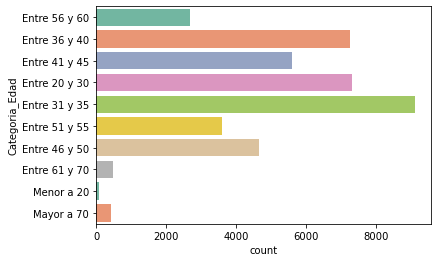

In [10]:
# Voy a ver algunos histogramas:

sns.countplot(y = 'Categoria_Edad', data = DF_Visualizacion, palette = 'Set2')

<AxesSubplot:xlabel='count', ylabel='job'>

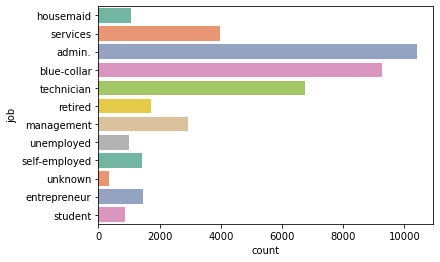

In [11]:
sns.countplot(y = 'job', data = Datos, palette = 'Set2')

<AxesSubplot:xlabel='count', ylabel='marital'>

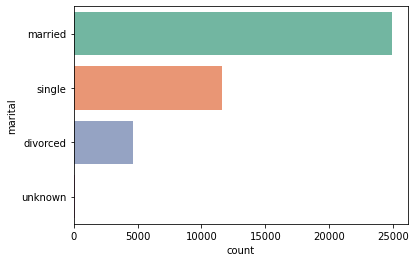

In [12]:
sns.countplot(y = 'marital', data = Datos, palette = 'Set2')

<AxesSubplot:xlabel='count', ylabel='education'>

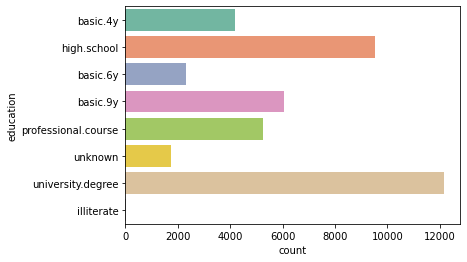

In [13]:
sns.countplot(y = 'education', data = Datos, palette = 'Set2')

<AxesSubplot:xlabel='count', ylabel='housing'>

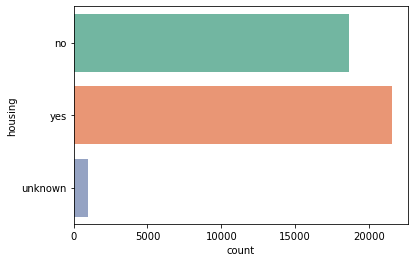

In [14]:
sns.countplot(y = 'housing', data = Datos, palette = 'Set2')

<AxesSubplot:xlabel='count', ylabel='month'>

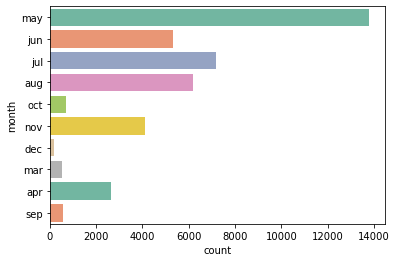

In [15]:
sns.countplot(y = 'month', data = Datos, palette = 'Set2')

<AxesSubplot:xlabel='count', ylabel='day_of_week'>

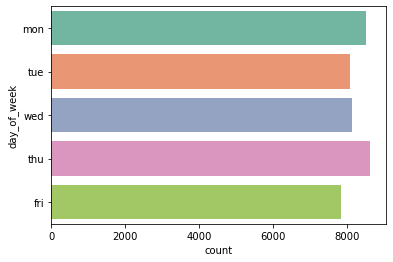

In [16]:
sns.countplot(y = 'day_of_week', data = Datos, palette = 'Set2')

<AxesSubplot:xlabel='count', ylabel='emp.var.rate'>

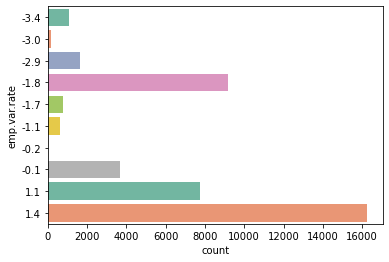

In [17]:
sns.countplot(y = 'emp.var.rate', data = Datos, palette = 'Set2')

<AxesSubplot:xlabel='count', ylabel='cons.price.idx'>

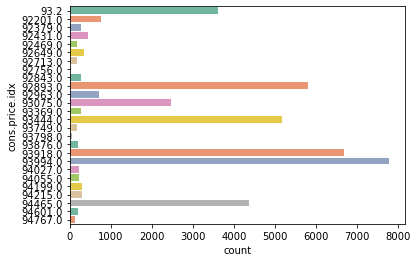

In [18]:
sns.countplot(y = 'cons.price.idx', data = Datos, palette = 'Set2')

<AxesSubplot:xlabel='count', ylabel='nr.employed'>

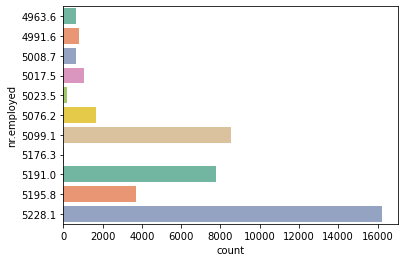

In [19]:
sns.countplot(y = 'nr.employed', data = Datos, palette = 'Set2')

<AxesSubplot:xlabel='count', ylabel='y'>

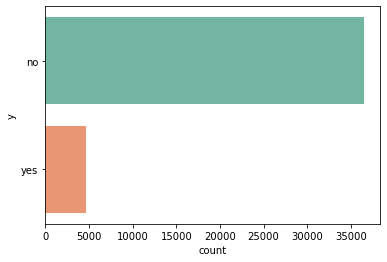

In [20]:
sns.countplot(y = 'y', data = Datos, palette = 'Set2')

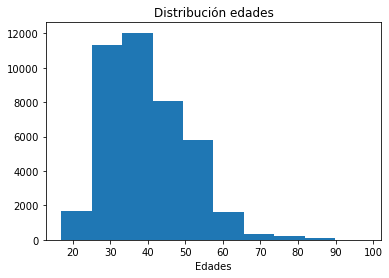

In [21]:
# De ver estos gráficos puedo concluir que hay cierta tendencia a valores particulares en:
# Categoria_Edad, job, marital, month, emp.var.rate y nr.employed. 
# Por último, resulta útil ver que solo alrededor del 15% de las personas contactadas decidieron 
# tomar el depósito.

# A continuación voy a ver la distribución de algunas de las variables numéricas, para ver si
# tienen distribución normal o no:

plt.hist(Datos['age'])
plt.xlabel('Edades')
plt.title('Distribución edades');

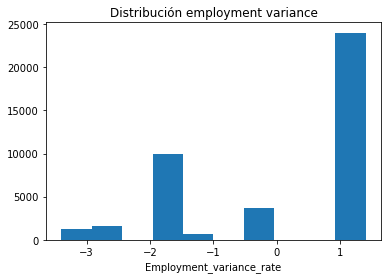

In [22]:
plt.hist(Datos['emp.var.rate'])
plt.xlabel('Employment_variance_rate')
plt.title('Distribución employment variance');

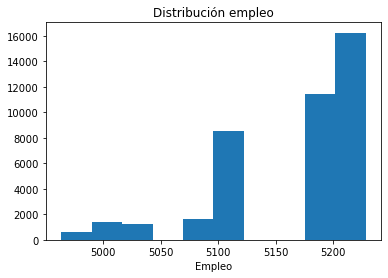

In [23]:
plt.hist(Datos['nr.employed'])
plt.xlabel('Empleo')
plt.title('Distribución empleo');

Solo puedo ver una tendencia normal en el grafico de edades.

In [24]:
# Voy a pasar los datos categoricos a numericos para poder hacer una visualizacion de matriz de correlación.
# Ademas va a ser necesario para poder implementar los modelos. para esto voy a utilizar el metodo de label encoding.
# Para esto primero va a ser necesario pasar los datos categoricos de dtype object (string) a category.:

Datos['job'] = Datos['job'].astype('category')
Datos['marital'] = Datos['marital'].astype('category')
Datos['education'] = Datos['education'].astype('category')
Datos['default'] = Datos['default'].astype('category')
Datos['housing'] = Datos['housing'].astype('category')
Datos['loan'] = Datos['loan'].astype('category')
Datos['contact'] = Datos['contact'].astype('category')
Datos['month'] = Datos['month'].astype('category')
Datos['day_of_week'] = Datos['day_of_week'].astype('category')
Datos['poutcome'] = Datos['poutcome'].astype('category')
Datos['y'] = Datos['y'].astype('category')
Datos.dtypes

# Un beneficio extra de tener estos datos como category en lugar de object es que va a mejorar la performance de
# todos los procesos.

age                  int64
job               category
marital           category
education         category
default           category
housing           category
loan              category
contact           category
month             category
day_of_week       category
campaign             int64
pdays                int64
previous             int64
poutcome          category
emp.var.rate       float64
cons.price.idx     float64
cons.conf.idx      float64
euribor3m          float64
nr.employed        float64
y                 category
dtype: object

In [25]:
Datos['job'] = Datos['job'].cat.codes
Datos['marital'] = Datos['marital'].cat.codes
Datos['education'] = Datos['education'].cat.codes
Datos['default'] = Datos['default'].cat.codes
Datos['housing'] = Datos['housing'].cat.codes
Datos['loan'] = Datos['loan'].cat.codes
Datos['contact'] = Datos['contact'].cat.codes
Datos['month'] = Datos['month'].cat.codes
Datos['day_of_week'] = Datos['day_of_week'].cat.codes
Datos['poutcome'] = Datos['poutcome'].cat.codes
Datos['y'] = Datos['y'].cat.codes
Datos.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,3,1,0,0,0,0,1,6,1,1,999,0,1,1.1,93994.0,-36.4,4857.0,5191.0,0
1,57,7,1,3,1,0,0,1,6,1,1,999,0,1,1.1,93994.0,-36.4,4857.0,5191.0,0
2,37,7,1,3,0,2,0,1,6,1,1,999,0,1,1.1,93994.0,-36.4,4857.0,5191.0,0
3,40,0,1,1,0,0,0,1,6,1,1,999,0,1,1.1,93994.0,-36.4,4857.0,5191.0,0
4,56,7,1,3,0,0,2,1,6,1,1,999,0,1,1.1,93994.0,-36.4,4857.0,5191.0,0


# Detección y eliminación de outliers:

<AxesSubplot:ylabel='age'>

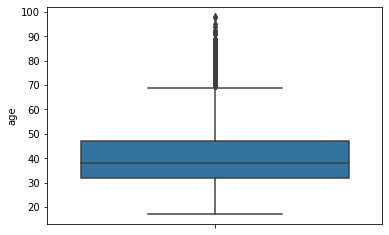

In [26]:
# Voy a hacer algunos boxplots para ver en que categorias hay outliers:

sns.boxplot(y='age',data=Datos)

<AxesSubplot:ylabel='job'>

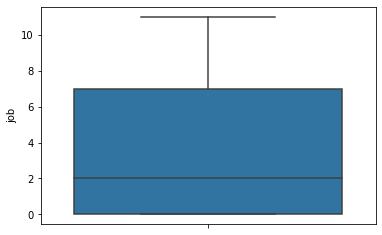

In [27]:
sns.boxplot(y='job',data=Datos)

<AxesSubplot:ylabel='marital'>

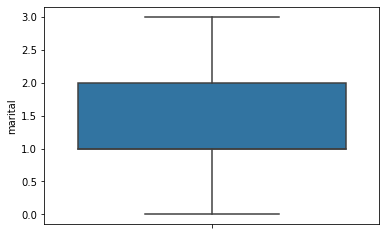

In [28]:
sns.boxplot(y='marital',data=Datos)

<AxesSubplot:ylabel='education'>

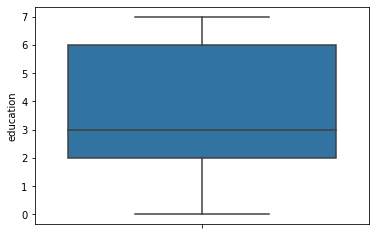

In [29]:
sns.boxplot(y='education',data=Datos)

<AxesSubplot:ylabel='month'>

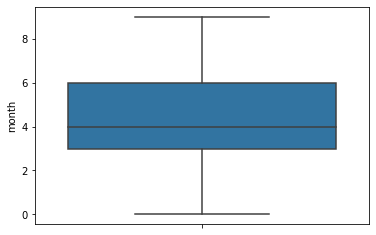

In [30]:
sns.boxplot(y='month',data=Datos)

<AxesSubplot:ylabel='day_of_week'>

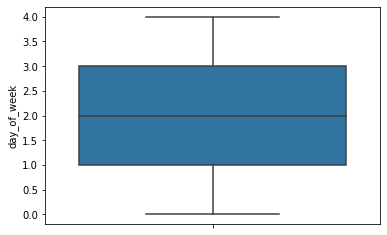

In [31]:
sns.boxplot(y='day_of_week',data=Datos)

<AxesSubplot:ylabel='campaign'>

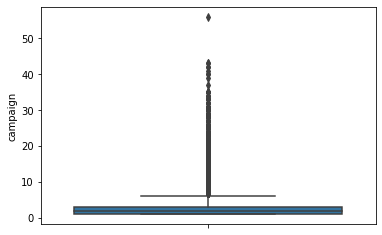

In [32]:
sns.boxplot(y='campaign',data=Datos)

<AxesSubplot:ylabel='emp.var.rate'>

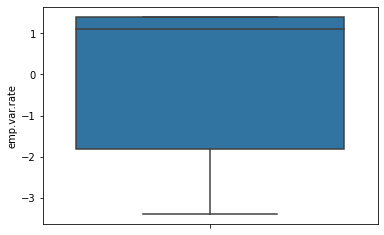

In [33]:
sns.boxplot(y='emp.var.rate',data=Datos)

<AxesSubplot:ylabel='cons.price.idx'>

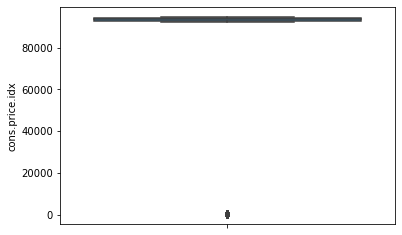

In [34]:
sns.boxplot(y='cons.price.idx',data=Datos)

<AxesSubplot:ylabel='cons.conf.idx'>

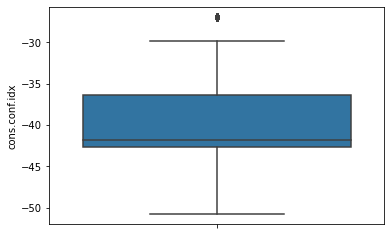

In [35]:
sns.boxplot(y='cons.conf.idx',data=Datos)

<AxesSubplot:ylabel='euribor3m'>

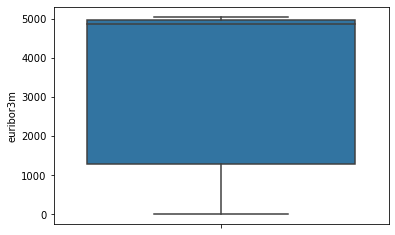

In [36]:
sns.boxplot(y='euribor3m',data=Datos)

<AxesSubplot:ylabel='nr.employed'>

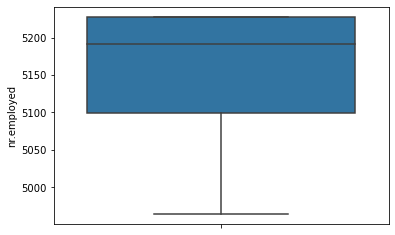

In [37]:
sns.boxplot(y='nr.employed',data=Datos)

In [38]:
# En los boxplot se pueden ver algunos casos con claros outliers: age, campaign, cons.price.idx y cons.conf.idx

# Voy a eliminar el percentil 1% (maximo o minimo, dependiendo el caso), y ver como se modifican los boxplots y los
# cuartiles.


Datos_sin_outliersAge = Datos.copy()
age_limite_max = Datos_sin_outliersAge['age'].quantile(0.99)
Datos_sin_outliersAge = Datos_sin_outliersAge[Datos_sin_outliersAge['age']<age_limite_max]
print(str(Datos_sin_outliersAge.shape[0]) + ' Datos despues de eliminar el percentil 1% de los maximos age')

Datos_sin_outliersCampaign = Datos_sin_outliersAge.copy()
campaign_limite_max = Datos_sin_outliersCampaign['campaign'].quantile(0.95)
Datos_sin_outliersCampaign = Datos_sin_outliersCampaign[Datos_sin_outliersCampaign['campaign']<campaign_limite_max]
print(str(Datos_sin_outliersCampaign.shape[0]) + ' Datos despues de eliminar el percentil 5% de los maximos campaign')

Datos_sin_outlierspri = Datos_sin_outliersCampaign.copy()
pri_limite_min = Datos_sin_outlierspri['cons.price.idx'].quantile(0.01)
Datos_sin_outlierspri = Datos_sin_outlierspri[Datos_sin_outlierspri['cons.price.idx']>pri_limite_min]
print(str(Datos_sin_outlierspri.shape[0]) + ' Datos despues de eliminar el percentil 1% de los minimos cons.price.idx')

Datos_sin_outliersconf = Datos_sin_outlierspri.copy()
conf_limite_max = Datos_sin_outliersconf['cons.conf.idx'].quantile(0.99)
Datos_sin_outliersconf = Datos_sin_outliersconf[Datos_sin_outliersconf['cons.conf.idx']<conf_limite_max]
print(str(Datos_sin_outliersconf.shape[0]) + ' Datos despues de eliminar el percentil 1% de los maximos cons.conf.idx')

40766 Datos despues de eliminar el percentil 1% de los maximos age
38374 Datos despues de eliminar el percentil 5% de los maximos campaign
34825 Datos despues de eliminar el percentil 1% de los minimos cons.price.idx
34429 Datos despues de eliminar el percentil 1% de los maximos cons.conf.idx


In [39]:
# Veo cuantos datos fueron eliminados:

Datos_sin_outliers = Datos_sin_outliersconf.copy()
print(Datos_sin_outliers.shape)
print(Datos.shape)

(34429, 20)
(41188, 20)


Luego de eliminar outliers de las 4 variables mencionadas anteriormente, quedan 36280 datos. Se eliminaron alrededor de un 16% de los datos. Este no es un número para nada menor y definitivamente hay que investigar mas sobre que tan correcto es eliminar esta cantidad. En este caso en particular, la mayor cantidad de datos eliminados proviene de descartar datos de un valor mínimo en la columna cons.price.idx (alrededor de un 9% fueron eliminados por este filtro). Al observar el boxplot de esta variable, se nota que hay una aglomeración de datos muy alejada del core de datos. Por ser asi, considero que seguir adelante habiendo filtrado ese conjunto de datos es correcto, ya que al estar tan alejados del resto de valores (y al ser tanta cantidad), podrian disminuir en gran medida la performance de los modelos.

Cuando vemos los outliers de campaing, se ve que solo se eliminan alrededor de 500 datos, incluso descartando todo lo que quede fuera de un parcentil 95%. Por esta razon considero que es razonable eliminar a estos datos.

Los outliers por edad se dan mas que nada removiendo edades elevadas. La decision de remover estas edades o no del modelo va a depender del publico objetivo de esta iniciativa. Si el objetivo de este programa incluye edades elevadas habra que generar un modelo que pueda predecir tambien valores tomando en cuenta este rango etario.

Si tuviera tiempo de ralizar un analisis mas exhaustivo, definitivamente experimentaria para tratar de entender si
eliminar estos datos es correcto o no.

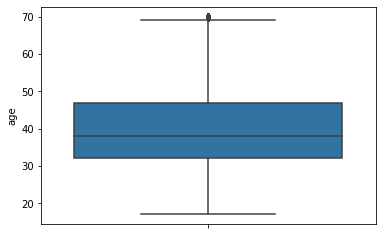

In [40]:
# Voy a volver a analizar los boxplot de las variables que recorte:

sns.boxplot(y='age',data=Datos_sin_outliers);

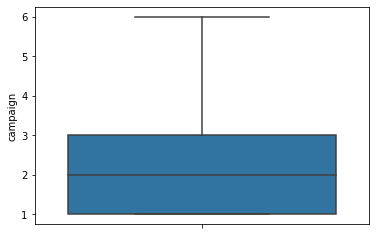

In [41]:
sns.boxplot(y='campaign',data=Datos_sin_outliers);

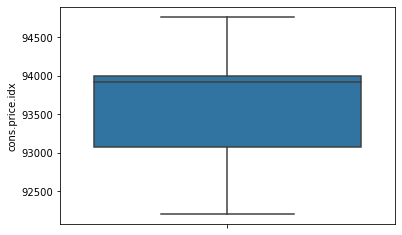

In [42]:
sns.boxplot(y='cons.price.idx',data=Datos_sin_outliers);

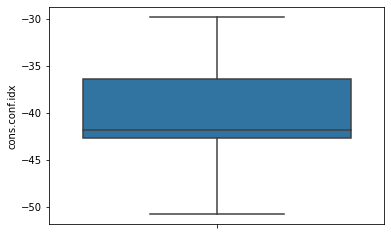

In [43]:
sns.boxplot(y='cons.conf.idx',data=Datos_sin_outliers);

La eliminacion de outliers resulto en boxplots mucho mejor distribuidos. Esto seguramente vaya a mejorar bastante
la performance de los modelos de clasificación.

# Heatmap de correlaciónes:

<AxesSubplot:>

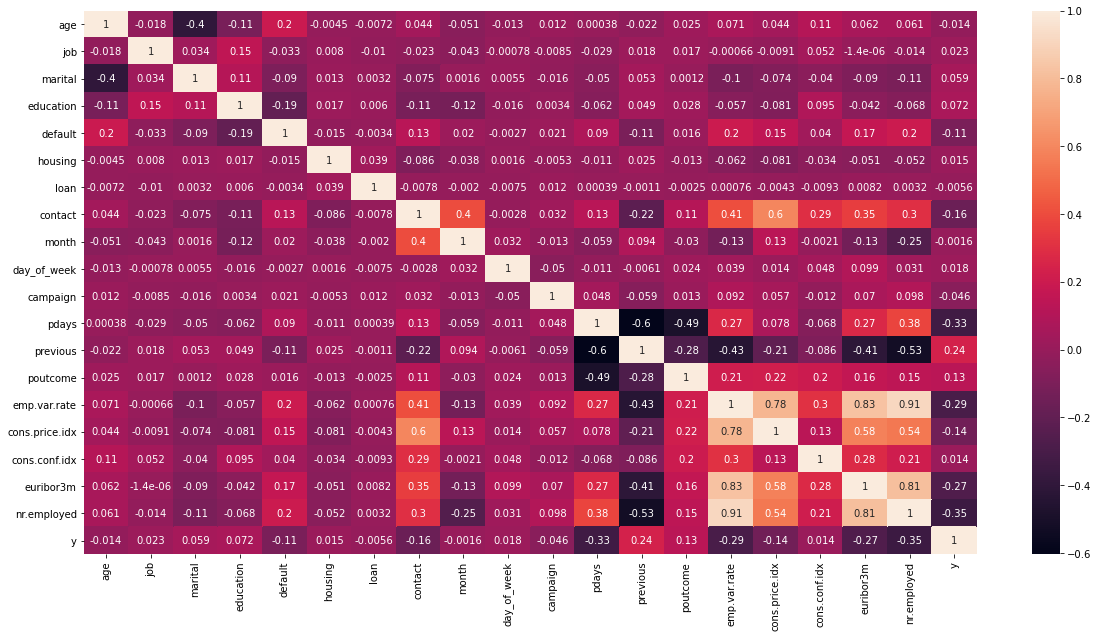

In [44]:
plt.figure(figsize=(20,10))
Correlaciones = sns.heatmap(Datos_sin_outliers.corr(),annot =True)
Correlaciones

Viendo el heatmap se puede identificar algunas de las variables que mas correlación presentan con la decision de deposito.
default, contact, pdays, previos, poutcome, nr.emploted. Voy a utilizar estas variables para construir el modelo, pero
no pdays ya que la mayoria de sus valores corresponden a 999. Este valor simboliza que no se contacto al cliente
previamente. Al tener tantos valores correspondientes a este valor, entiendo que no aporta mucha información.
No voy a considerar emp.var.rate, cons,price.idx, euribor3m ya que se nota que tienen multicolinearidad entre si y con
nr.employed. Al ser nr.employed la variable con mayor correlación con y, prefiero utilizar a esta.
La no multicolinearidad es un supuesto de muchos modelos de machine learning. Utilizar variables que presentan dependencia
entre si podria reducir la performance del modelo.

In [45]:
# Voy a generar un DataFrame que solo va a contener las variables que voy a utilizar para el modelo:

Datos_modelo = Datos_sin_outliers[['default', 'contact', 'previous', 'poutcome', 'nr.employed', 'y']]
Datos_modelo.shape

(34429, 6)

# Preparando los datos para los modelos de clasificación:

In [46]:
# Defino las variables:

x = Datos_modelo.drop(['y'], axis=1)
y = Datos_modelo['y']

In [47]:
# Voy a separar los datos que quedaron luego de filtrar outliers y tomar las variables que me parecen van a arrojar mejores
# resultados:

(x_train,x_test,y_train,y_test) = train_test_split(x,y,test_size=0.2)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(27543, 5)
(6886, 5)
(27543,)
(6886,)


In [48]:
# Por ultimo, voy a estandarizar los datos. Esto lo hago para que variables con valores mas altos no ganen mas peso
# cuando el algoritmo va a realizar la clasificación. Este paso se realiza luego de separar los datos para no 
# estandarizar la variable dependiente:

Standard = StandardScaler()
x_train_Std = Standard.fit_transform(x_train)
x_test_Std = Standard.transform(x_test)

# Entrenando al algoritmo de clasificación:

## Vecinos cercanos:

In [49]:
KNN = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
KNN.fit(x_train_Std, y_train)

KNeighborsClassifier()

In [50]:
prediccionKNN = KNN.predict(x_test_Std)
KNN.score(x_test_Std,y_test)

0.8919546906767354

In [51]:
# Matriz de confusión:

confusionKNN = metrics.confusion_matrix(y_test, prediccionKNN)
pd.DataFrame({'Predecido N': [confusionKNN[0,0], confusionKNN[1,0]], 
              'Predecido P': [confusionKNN[0,1], confusionKNN[1,1]],
              '%': [confusionKNN[0,0]*100/(confusionKNN[0,0]+confusionKNN[0,1]), \
                    confusionKNN[1,1]*100/(confusionKNN[1,0]+confusionKNN[1,1])]},
             index=['Realidad N', 'Realidad P'])

,Predecido N,Predecido P,%
Realidad N,5969,101,98.336079
Realidad P,643,173,21.200980


## Arbol de decisiones:

In [52]:
ArbolDD = DecisionTreeClassifier()
ArbolDD.fit(x_train_Std, y_train)

DecisionTreeClassifier()

In [53]:
prediccionADD = ArbolDD.predict(x_test_Std)
ArbolDD.score(x_test_Std, y_test)

0.8983444670345628

In [54]:
# Matriz de confusión:

confusionADD = metrics.confusion_matrix(y_test, prediccionADD)
pd.DataFrame({'Predecido N': [confusionADD[0,0], confusionADD[1,0]], 
              'Predecido P': [confusionADD[0,1], confusionADD[1,1]],
              '%': [confusionADD[0,0]*100/(confusionADD[0,0]+confusionADD[0,1]), \
                    confusionADD[1,1]*100/(confusionADD[1,0]+confusionADD[1,1])]},
             index=['Realidad N', 'Realidad P'])

,Predecido N,Predecido P,%
Realidad N,5955,115,98.105437
Realidad P,585,231,28.308824


## Bayes ingenuo:

In [55]:
Bayes = GaussianNB()
Bayes.fit(x_train_Std, y_train)

GaussianNB()

In [56]:
prediccionBayes = Bayes.predict(x_test_Std)
Bayes.score(x_test_Std,y_test)

0.8409817020040662

In [57]:
# Matriz de confusión:

confusionB = metrics.confusion_matrix(y_test, prediccionBayes)
pd.DataFrame({'Predecido N': [confusionB[0,0], confusionB[1,0]], 
              'Predecido P': [confusionB[0,1], confusionB[1,1]],
              '%': [confusionB[0,0]*100/(confusionB[0,0]+confusionB[0,1]), \
                    confusionB[1,1]*100/(confusionB[1,0]+confusionB[1,1])]},
             index=['Realidad N', 'Realidad P'])

,Predecido N,Predecido P,%
Realidad N,5479,591,90.263591
Realidad P,504,312,38.235294


## Random Forest

In [58]:
RandomF = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
RandomF.fit(x_train_Std, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10)

In [59]:
prediccionRF = RandomF.predict(x_test_Std)
RandomF.score(x_test_Std,y_test)

0.897908800464711

In [60]:
#Matriz de confusión:

confusionRF = metrics.confusion_matrix(y_test, prediccionRF)
pd.DataFrame({'Predecido N': [confusionRF[0,0], confusionRF[1,0]], 
              'Predecido P': [confusionRF[0,1], confusionRF[1,1]],
              '%': [confusionRF[0,0]*100/(confusionRF[0,0]+confusionRF[0,1]), \
                    confusionRF[1,1]*100/(confusionRF[1,0]+confusionRF[1,1])]},
             index=['Realidad N', 'Realidad P'])

,Predecido N,Predecido P,%
Realidad N,5949,121,98.006590
Realidad P,582,234,28.676471


## Regresión logistica:

In [61]:
RegresionLog=LogisticRegression()
RegresionLog.fit(x_train_Std, y_train)

LogisticRegression()

In [62]:
prediccionRegLog = RegresionLog.predict(x_test_Std)
RegresionLog.score(x_test_Std,y_test)

0.8973279117049086

In [63]:
#Matriz de confusión:

confusionRegLog = metrics.confusion_matrix(y_test, prediccionRegLog)
pd.DataFrame({'Predecido N': [confusionRegLog[0,0], confusionRegLog[1,0]], 
              'Predecido P': [confusionRegLog[0,1], confusionRegLog[1,1]],
              '%': [confusionRegLog[0,0]*100/(confusionRegLog[0,0]+confusionRegLog[0,1]), \
                    confusionRegLog[1,1]*100/(confusionRegLog[1,0]+confusionRegLog[1,1])]},
             index=['Realidad N', 'Realidad P'])

,Predecido N,Predecido P,%
Realidad N,6006,64,98.945634
Realidad P,643,173,21.200980


## Grafico ROC:

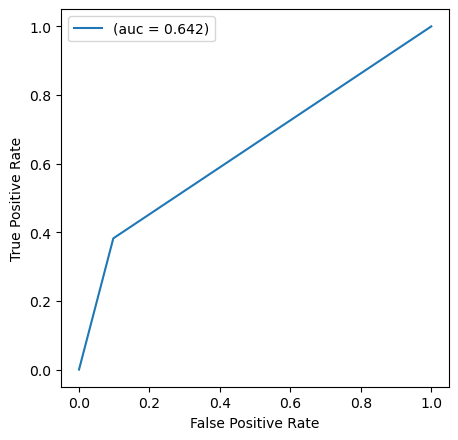

In [64]:
fpr,tpr,threshold =roc_curve(y_test,prediccionBayes)
auc = auc(fpr,tpr)
plt.figure(figsize=(5,5),dpi=100)
plt.plot(fpr,tpr,linestyle='-',label = "(auc = %0.3f)" % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Conclusiones:

De los 5 modelos utilizados para realizar la clasificación (vecinos cercanos, árbol de decisiones, Bayes ingenuo, random forest y regresión logística) árbol de decisiones fue el que arrojo un mejor score, dando 98,1% de predicciones acertadas en datos negativos y un 28,3% en casos positivos.
Sin embargo, Si se busca maximizar la cantidad de casos positivos predichos correctamente (restándole importancia a predecir erróneamente casos negativos), se tendría que usare Bayes ingenuo, ya que logra el mayor % de valores positivos predichos correctamente, 38,2%. 
Desde el punto de vista del negocio, este último enfoque podría tener mas sentido ya que se estarían generando mayor cantidad de préstamos. posiblemente el esfuerzo extra resultante de realizar llamadas pensando que van a ser positivas cuando en realidad son negativas no supere la ganancia de captar más clientes.
También es destacable que en general, ningún modelo arrojo valores elevados de predicción de casos positivos. Este es definitivamente un punto de mejora del análisis (al final del documento describo una serie de pasos que haría para mejorarlo).


# Como mejoraria el analisis si tuviera un poco mas de tiempo:

Mejoraria la transformacion de datos categoricos en numericos. Una desventaja del label encoder es que asigna numeros
sin asignar una importancia a cada label en particular. Este tipo de datos puede ser mal interpretado por el algoritmo
ya que proporciona mas peso a ciertos valores categoricos por sobre otros sin una verdadera razon detras.

Analizaria un poco mas a fondo en que casos el Dataset presenta valores unknown. Podria proporcionar valor entender mejor
si hay alguna razon particular o razonamiento detras de la asignacion de este valor. Por ejemplo, en 'gender', un unknown
podria representar personas que no se identifican con masculino ni con femenino y no simplemente un valor no completado por error. Podria resultar interesante analizar como se relaciona esta asignación con otras variables y con la probabilidad de que acepte o no el deposito.

Experimentaria un poco mas con que datos elimino por outliers. Especificamente, que percentiles puedo dejar adentro 
y cuales afuera del analisis.

Pdays tiene valores 999 que representan que no hubo contacto previo en otra campaña con el cliente. Evaluar si tener tantos casos en los que no hubo contacto podria estar afectando la tasa de aceptación del deposito.

Probaria cambiar las variables con las que estoy armando los modelos. Principalmente intentaria remover la que menor correlacion tenga para ver si puedo mejorar la predicción.

## Cosas que googlie:

- Código para hacer label encoding. pensé en hacerlo reemplazando manualmente cada valor categórico por uno numérico asignado por mí, pero sabía que hay métodos que lo hacen directamente y este ejercicio fue una buena excusa para buscarlo.

- Definiciones de cons.price.idx, cons.conf.idx y euribor3m.

- Tenía una noción de como eliminar los outliers pero me asegure de hacerlo bien buscando que método puede ser más sencillo. Estaba en lo cierto buscando fijar el percentil limite que quiero establecer y redefiniendo el data frame para que deje fuera todo lo que no este dentro del límite establecido.

- Código para generar matriz de confusión y el gráfico ROC. Entiendo los conceptos de ambos y podría hacerlo manualmente, pero igual que con label encoding, fue una buena excusa para buscar métodos que simplificaran el código.

- A los modelos de clasificación ya los conocía, pero googlear como es exactamente el código fue útil para confirmarlo.